In [7]:
from collections import defaultdict, deque, Counter
import numpy as np
from tqdm import tqdm_notebook as tqdm 
import pandas as pd

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

# For plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
!pip install ipympl
import ipympl

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [9]:
filename = "cheetah.cs.fiu.edu-110108-113008.1.blkparse"
df = pd.read_csv(filename, sep=' ',header = None)
df.columns = ['timestamp','pid','pname','blockNo', \
              'blockSize', 'readOrWrite', 'bdMajor', 'bdMinor', 'hash']
blocktrace = df['blockNo'].tolist()
len(blocktrace)

1322890

In [10]:
def belady_opt(blocktrace, frame):
    '''
    INPUT
    ==========
    blocktrace = list of block request sequence
    frame = size of the cache
    
    OUTPUT
    ==========
    hitrate 
    '''
    infinite_index = 10000 * len(blocktrace) # should be a large integer
    
    block_index = defaultdict(deque) 
    # dictionary with block number as key and list
    # of index value in blocktrace
    
    upcoming_index = defaultdict(int)
    # dictionary with index number as key and value as block
    
    frequency = defaultdict(int)
    # dictionary of block as key and number
    # of times it's been requested so far
    
    recency = list()
    # list of block in order of their request
    
    Cache = deque()
    # Cache with block
    
    dataset = np.array([]).reshape(0,3*frame+1)
    #columns represents the number of block in cache and 
    #3 is the number of features such as frequency, recency and block number
    #+1 is for label 0-1
    
    d3_fin=np.array([]).reshape(0,3)
    
    hit, miss = 0, 0
    
    # populate the block_index
    for i, block in enumerate(tqdm(blocktrace, \
                              desc="buidling index", leave=False)):
        block_index[block].append(i)
        
    # sequential block requests start
    for i, block in enumerate(tqdm(blocktrace, desc="sequence", leave=False)):
        
        # increament the frequency number for the block
        frequency[block] += 1
        
        # make sure block has the value in block_index dictionary 
        # as current seq_number
        if len(block_index[block]) != 0 and block_index[block][0] == i:
            
            # if yes, remove the first element of block_index[block]
            block_index[block].popleft()
        
        # if block exist in current cache
        if block in Cache:
            
            # increment hit
            hit += 1
            
            # update the recency
            recency.remove(block)
            recency.append(block)
            
            # update upcoming_index
            if i in upcoming_index:
                
                # delete old index
                del upcoming_index[i]
        
                if len(block_index[block]) is not 0:
                    # add new upcoming index
                    upcoming_index[block_index[block][0]] = block
                    # remove index from block_index
                    block_index[block].popleft()
                else:
                    # add a large integer as index
                    upcoming_index[infinite_index] = block
                    # increament large integer
                    infinite_index-=1
           
        # block not in current cache
        else:
            
            # increament miss
            miss += 1
            
            # if cache has no free space
            if len(Cache) == frame:
                
                
                # evict the farthest block in future request from cache
                if len(upcoming_index) != 0:
                    
                    # find the farthest i.e. max_index in upcoming_index
                    max_index = max(upcoming_index)
                    
                    if (i % 1000 +1 == 1000):
                        blockNo = np.array([i for i in Cache])
                        blockNo = blockNo / np.linalg.norm(blockNo)
                        recency_ = np.array([recency.index(i) for i in Cache])
                        recency_ = recency_ / np.linalg.norm(recency_)
                        frequency_ = np.array([frequency[i] for i in Cache])
                        frequency_ = frequency_ / np.linalg.norm(frequency_)
                        d3=np.column_stack((blockNo, recency_, frequency_))
                        d3_fin=np.vstack((d3_fin, d3))
                        stack = np.column_stack((blockNo, recency_, frequency_)).reshape(1,frame*3)
                        stack = np.append(stack, Cache.index(upcoming_index[max_index]))
                        dataset = np.vstack((dataset, stack))
                    # remove the block with max_index from cache
                    Cache.remove(upcoming_index[max_index])
                    
                    # remove the block with max_index from recency dict
                    recency.remove(upcoming_index[max_index])
                    
                    # remove max_index element from upcoming_index
                    del upcoming_index[max_index]
                    
            # add upcoming request of current block in upcoming_index
            if len(block_index[block]) != 0:
                
                # add upcoming index of block
                upcoming_index[block_index[block][0]] = block
               
                # remove the index from block_index 
                block_index[block].popleft()
            
            else:
                
                # add a large integer as index
                upcoming_index[infinite_index] = block
                
                # increament high number
                infinite_index -= 1
                
                
            
            # add block into Cache
            Cache.append(block)
            
            # add block into recency
            recency.append(block)
            
            
    # calculate hitrate
    hitrate = hit / (hit + miss)

    return hitrate, dataset,d3_fin

In [11]:
hitrate, dataset,D3 = belady_opt(blocktrace, 1000)

In [21]:
X=D3[:1000,0]
Y=D3[:1000,1]
Z=D3[:1000,2]

<IPython.core.display.Javascript object>


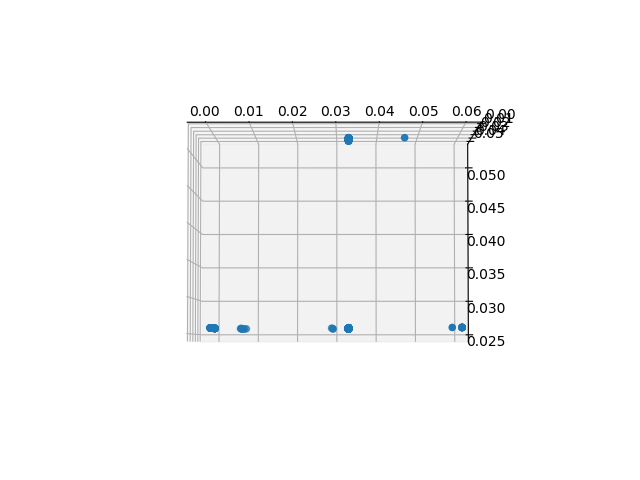

In [22]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X, Y, Z)